In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
df = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


C:\Users\Hp\anaconda3\lib\site-packages\yfinance\utils.py:711: UserWarning: Pandas requires version '2022.1' or newer of 'tzdata' (version '2021.1' currently installed).
  md[k] = _pd.to_datetime(md[k], unit='s', utc=True).tz_convert(tz)


In [2]:
df = df['Adj Close']
df.head()

Date
1980-12-12    0.099584
1980-12-15    0.094388
1980-12-16    0.087461
1980-12-17    0.089625
1980-12-18    0.092224
Name: Adj Close, dtype: float64

In [3]:
df=df.fillna(method='ffill')

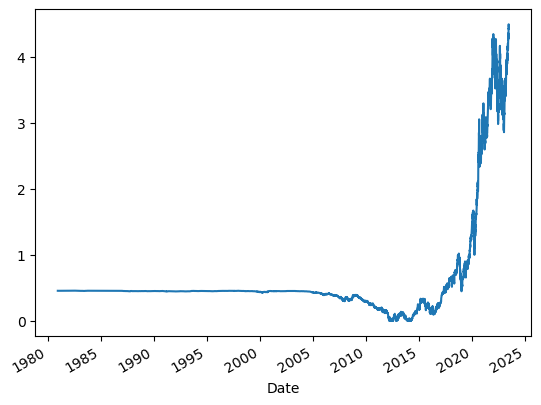

In [4]:
from scipy import stats
z_scores = np.abs(stats.zscore(df))


In [6]:

df.index = pd.date_range(start=df.index[0], periods=len(df), freq='D')

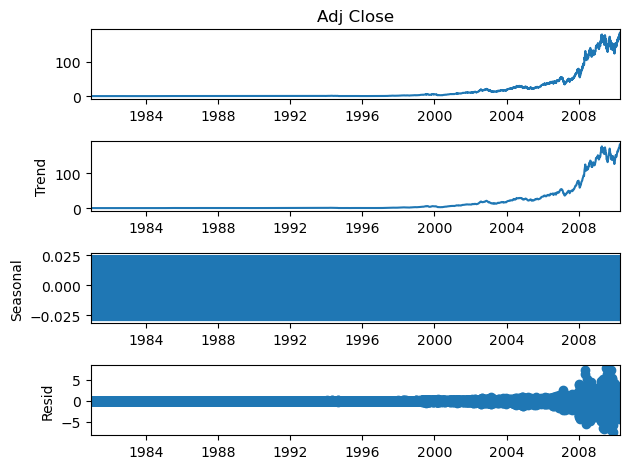

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels as sm
df_decom = seasonal_decompose(df,model='additive')
plot = df_decom.plot()

In [9]:
df_mul = seasonal_decompose(df,model='multiplicative')

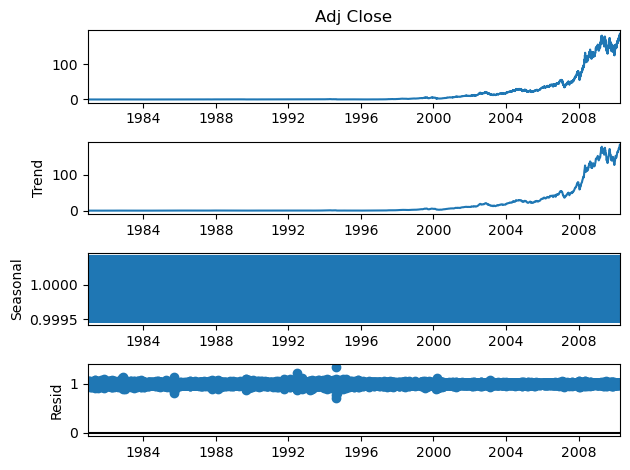

In [10]:
plot = df_mul.plot()

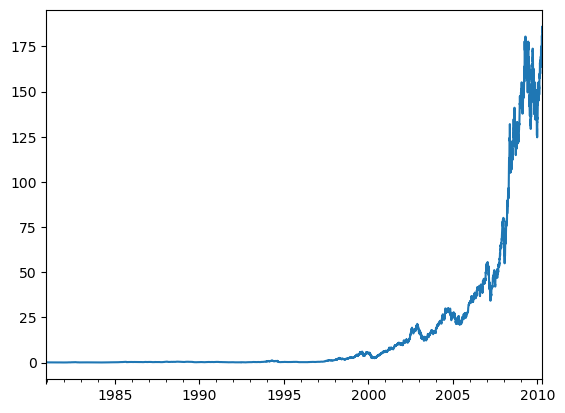

In [11]:
plot = df.plot()
#Since magnitude of seasonal component is increasing , we should accept multiplicative model

In [12]:
from statsmodels.tsa.filters.hp_filter import hpfilter
cycle, trend = hpfilter(df)

<Axes: title={'center': 'AAPL Trend Component'}>

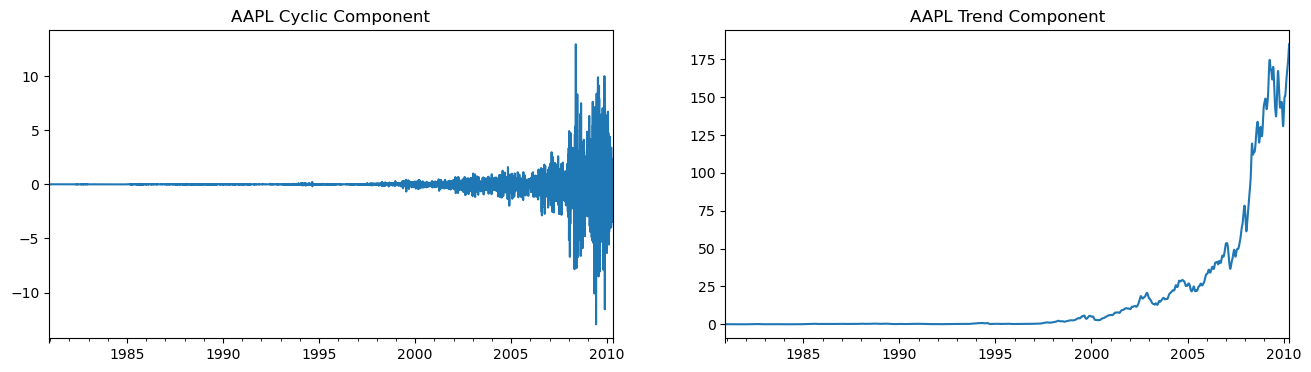

In [13]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
cycle.plot(ax=ax[0], title='AAPL Cyclic Component')
trend.plot(ax=ax[1], title='AAPL Trend Component')

# Test for Stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller, kpss
result_adf = adfuller(df)
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"{key}: {value}")

# Perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
result_kpss = kpss(df)
print("KPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f"{key}: {value}")

ADF Statistic: 4.037678164346836
p-value: 1.0
Critical Values:
1%: -3.4309625559762025
5%: -2.86181071519642
10%: -2.566914096559678
KPSS Statistic: 8.052700049392756
p-value: 0.01
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The p-values suggest that data is not stationary
Now performing test on residual of data

In [45]:


decomposition = seasonal_decompose(df, model='additive')

# Extract the residual component
residual = decomposition.resid
residual = residual.dropna()


In [46]:
result_adf = adfuller(residual)
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"{key}: {value}")

# Perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
result_kpss = kpss(residual)
print("KPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f"{key}: {value}")

ADF Statistic: -25.99551847716578
p-value: 0.0
Critical Values:
1%: -3.4309629004496336
5%: -2.8618108674185434
10%: -2.566914177587345
KPSS Statistic: 0.03520255633962705
p-value: 0.1
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Make the series stationary

In [48]:
#sqrt method
df_sqrt = np.sqrt(df)
#differencing method
df_diff = df.diff().dropna()
resid_diff = residual.diff().dropna()
#double difference
df_dif2 = df.diff().diff().dropna()
resid_dif2 = residual.diff().diff().dropna()

In [49]:
result_adf = adfuller(df_sqrt)
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:")
for key, value in result_adf[4].items():
    print(f"{key}: {value}")

# Perform the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
result_kpss = kpss(df_sqrt)
print("KPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])
print("Critical Values:")
for key, value in result_kpss[3].items():
    print(f"{key}: {value}")

ADF Statistic: 3.893589053051172
p-value: 1.0
Critical Values:
1%: -3.4309625559762025
5%: -2.86181071519642
10%: -2.566914096559678
KPSS Statistic: 12.214872533278108
p-value: 0.01
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


So upon taking sqrt, the series became stationary

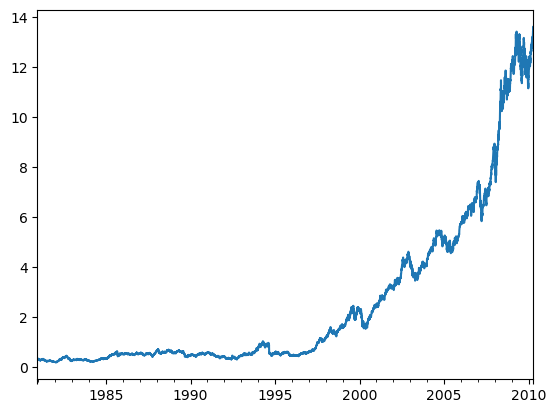

In [50]:
plot = df_sqrt.plot()

# Test for Normality

In [51]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

In [52]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [57]:
print(is_normal(shapiro(df)))
print(is_normal(shapiro(df_sqrt)))

Not Normal
Not Normal


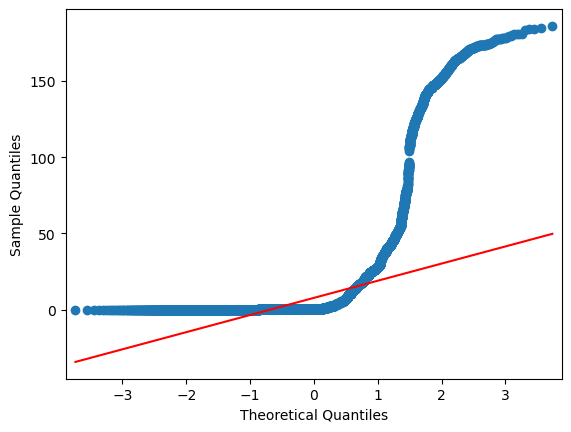

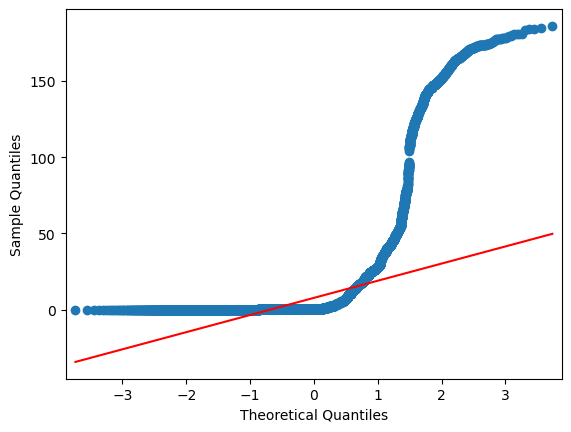

In [58]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df, line='q')

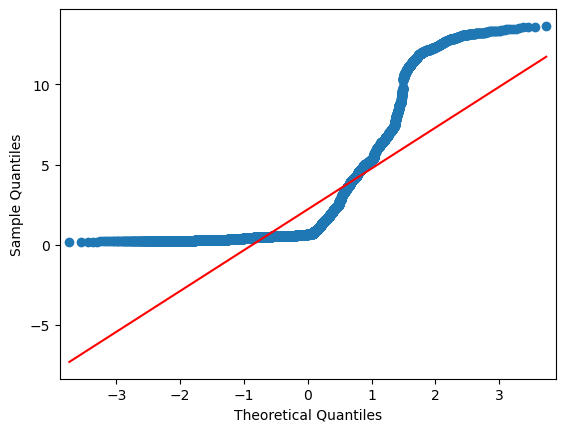

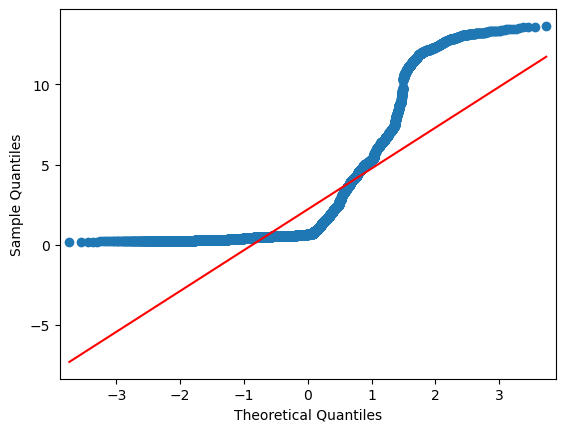

In [59]:
qqplot(df_sqrt,line='q')

Series can't be considered normal

# Test for Homoscedasticity and Apply Box-Cox Transformation


In [60]:
from statsmodels.stats.api import (het_breuschpagan, het_white)

In [65]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.tools import add_constant
model = AutoReg(df_sqrt.dropna(), lags=1, trend='n').fit()
resid = model.resid
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, 
                         add_constant(
                             model.fittedvalues)
                        ))
    
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"
het_test(model, test=het_breuschpagan)



'Heteroskedastic'

In [66]:
from scipy.stats import boxcox

In [67]:
xt, lmbda = boxcox(df)

In [68]:
xts = pd.Series(xt, index=df.index)

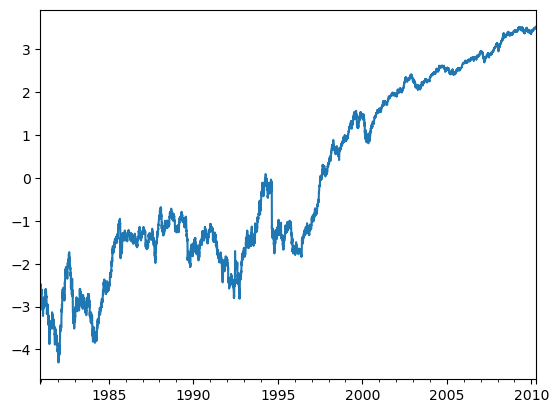

In [69]:
plot = xts.plot()

In [72]:
model = AutoReg(xts.dropna(), lags=1, trend='n').fit()
het_test(model, test=het_breuschpagan)


'Heteroskedastic'

In [73]:
from statsmodels.stats.diagnostic import acorr_ljungbox

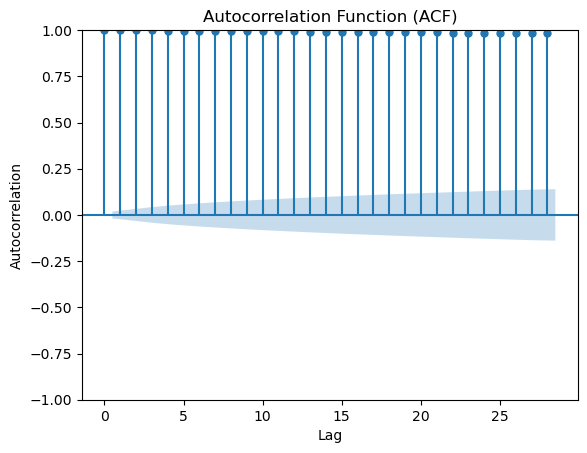

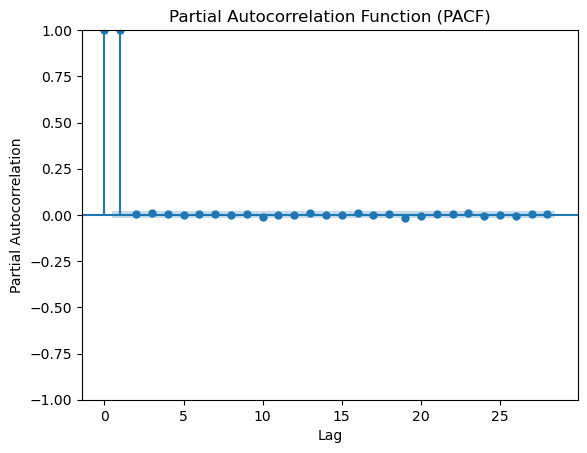

In [75]:
# Plot ACF
lags = 28
sm.graphics.tsa.plot_acf(df_sqrt, lags=lags, alpha=0.05)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df_sqrt, lags=lags, alpha=0.05)
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()


In [80]:
# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
train_data, test_data = train_test_split(df_sqrt, test_size=0.2, shuffle=False)


ar_model = AutoReg(df_sqrt.dropna(), lags=1, trend='n').fit()
# Making predictions on the testing set
predictions = ar_model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
# Calculating evaluation metrics
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)



Mean Squared Error (MSE): 0.007074613769528332
Mean Absolute Error (MAE): 0.05533470417340446
